In [1]:
# imports
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.layers import Input, Embedding, Conv1D, Bidirectional, LSTM
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Softmax, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# read in data
df = pd.read_csv("games.csv")

# remove id, rated, increment_code, white_id, white_rating, black_id, black_rating, opening_name, opening_ply
drop_columns = [
    "id", 
    "rated", 
    "increment_code",
    "white_id",
    "white_rating",
    "black_id",
    "black_rating",
    "opening_name",
    "opening_ply",
    "created_at",
    "last_move_at"
]

df.drop(columns=drop_columns, inplace=True)

# filter out rows where "victory_status" is not "resign" or "mate"
df = df[df["victory_status"].isin(["resign", "mate"])]

print("\nData after filtering on victory_status (keeping only 'resign' or 'mate'):")
print(df.head())

print("Number of rows:", len(df))

# turn “moves” string into a list of plies
df['move_list'] = df['moves'].str.split()

# keep only games with at least 16 plies
n = 16
df = df[df['move_list'].map(len) >= n]

# grab exactly first 16 plies
df['first_n'] = df['move_list'].map(lambda L: L[:n])
df['first_n_str'] = df['first_n'].apply(lambda L: ' '.join(L))

# build label y
# map white wins -> 1, black wins -> 0
df = df[df['winner'].isin(['white','black'])]


Data after filtering on victory_status (keeping only 'resign' or 'mate'):
   turns victory_status winner  \
1     16         resign  black   
2     61           mate  white   
3     61           mate  white   
4     95           mate  white   
6     33         resign  white   

                                               moves opening_eco  
1  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...         B00  
2  e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...         C20  
3  d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...         D02  
4  e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...         C41  
6  d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...         D00  
Number of rows: 17472


Fold 1 — Train Loss: 0.4511, Train Acc: 0.7734 | Val Loss: 0.9302, Val Acc: 0.5688
Fold 2 — Train Loss: 0.4806, Train Acc: 0.7578 | Val Loss: 0.8796, Val Acc: 0.5667
Fold 3 — Train Loss: 0.4658, Train Acc: 0.7650 | Val Loss: 0.8977, Val Acc: 0.5724
Fold 4 — Train Loss: 0.4952, Train Acc: 0.7403 | Val Loss: 0.8428, Val Acc: 0.5855
Fold 5 — Train Loss: 0.4797, Train Acc: 0.7525 | Val Loss: 0.9193, Val Acc: 0.5646


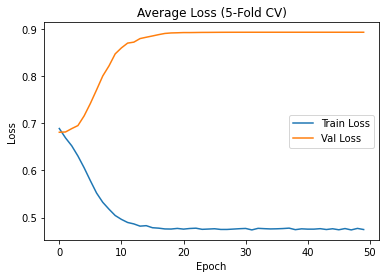

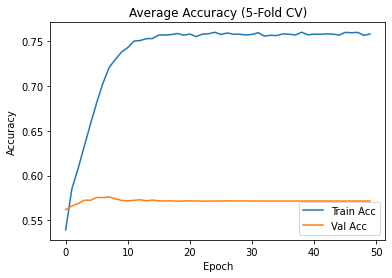

In [3]:
# split off test set on the raw text
X_str = df['first_n_str']
y     = (df['winner']=='white').astype(int).values

X_train_str, X_test_str, y_train, y_test = train_test_split(
    X_str, y, test_size=0.10, stratify=y, random_state=42
)

# fit Tokenizer on TRAIN ONLY
tok = Tokenizer(oov_token='<OOV>')
tok.fit_on_texts(X_train_str)

# convert to int sequences & pad for both splits
seq_tr = tok.texts_to_sequences(X_train_str)
seq_te = tok.texts_to_sequences(X_test_str)

X_train = pad_sequences(seq_tr, maxlen=n, padding='post', truncating='post')
X_test  = pad_sequences(seq_te, maxlen=n, padding='post', truncating='post')

# hyperparameters
embed_dim = 128
filters = 64
kernel_size = 3
lstm_units = 128
dropout_rate = 0.3
vocab_size = len(tok.word_index) + 1
seq_length = n
epochs = 50
batch_size = 32

def build_model():
    inputs = Input(shape=(seq_length,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
    x = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(
        LSTM(lstm_units, return_sequences=True, 
             dropout=dropout_rate, recurrent_dropout=dropout_rate)
    )(x)
    attn_scores  = Dense(1, activation='tanh')(x)
    attn_weights = Softmax(axis=1)(attn_scores)
    context      = Lambda(lambda t: tf.reduce_sum(t[0] * t[1], axis=1))([attn_weights, x])
    context      = Dropout(dropout_rate)(context)
    outputs      = Dense(1, activation='sigmoid')(context)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
histories = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_tr, X_va = X_train[train_idx], X_train[val_idx]
    y_tr, y_va = y_train[train_idx], y_train[val_idx]
    
    tf.keras.backend.clear_session()
    model = build_model()
    rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    
    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[rl],
        verbose=0
    )
    histories.append(history.history)
    
    train_loss = history.history["loss"][-1]
    train_acc  = history.history["accuracy"][-1]
    val_loss   = history.history["val_loss"][-1]
    val_acc    = history.history["val_accuracy"][-1]
    
    print(
        f"Fold {fold} — "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

# compute average metrics across folds
hist_arr = histories
avg_loss     = np.mean([h['loss']       for h in hist_arr], axis=0)
avg_val_loss = np.mean([h['val_loss']   for h in hist_arr], axis=0)
avg_acc      = np.mean([h['accuracy']   for h in hist_arr], axis=0)
avg_val_acc  = np.mean([h['val_accuracy'] for h in hist_arr], axis=0)

# plot loss
plt.figure()
plt.plot(avg_loss)
plt.plot(avg_val_loss)
plt.title('Average Loss (5-Fold CV)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Val Loss'])
plt.show()

# plot accuracy
plt.figure()
plt.plot(avg_acc)
plt.plot(avg_val_acc)
plt.title('Average Accuracy (5-Fold CV)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train Acc', 'Val Acc'])
plt.show()

In [4]:
# rebuild a fresh model
final_model = build_model()

# train it on all training data (X_train, y_train)
final_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2)],
    verbose=0
)

# evaluate exactly once on untouched test set
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.5875
